# Parte III: modelo de pronóstico de inflación en Guatemala con RNN

Statistical Learning II

*Rodrigo Chang*

*Carné: 19000625*

En esta parte del proyecto se implementa un modelo de redes neuronales recurrentes para modelar la evolución de la inflación en Guatemala, medida por el Índice de Precios al Consumidor. En este caso, se utiliza el método de ventanas para modelar la secuencia de valores de inflación, en el cual se utilizan valores previos de la secuencia para pronosticar el siguiente elemento de la secuencia.

## Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Métricas y preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Redes neuronales
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Carga de datos y visualización

In [2]:
# Cargamos el IPC de Guatemala y sus variaciones interanuales
data = pd.read_csv('ipc-guatemala.csv')
data2000 = data.iloc[132:, :]
# Revisamos información de los últimos 6 meses
data2000.tail(6)

,Fecha,IPC,Var.IPC
350,Mar-19,139.11,4.171035
351,Apr-19,139.95,4.752994
352,May-19,140.32,4.536989
353,Jun-19,141.48,4.800000
354,Jul-19,141.40,4.369649
355,Aug-19,140.18,3.012934


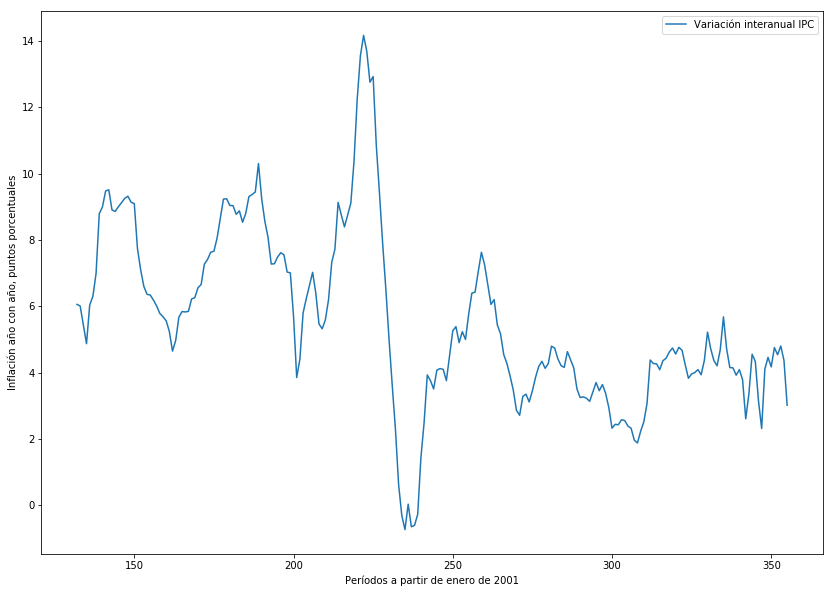

In [3]:
# Graficamos las variaciones interanuales históricas
plt.figure(figsize=(14,10))
plt.plot(data2000["Var.IPC"], label="Variación interanual IPC")
plt.xlabel("Períodos a partir de enero de 2001")
plt.ylabel("Inflación año con año, puntos porcentuales")
plt.legend();

In [4]:
# Semilla 
np.random.seed(7)

In [5]:
# Configuramos el conjunto de datos
dataset = data2000["Var.IPC"].values.astype(np.float32)
dataset = np.reshape(dataset, (-1, 1))
dataset[-6:]

array([[4.171035 ],
       [4.752994 ],
       [4.5369887],
       [4.8      ],
       [4.3696485],
       [3.0129335]], dtype=float32)

## Transformación del conjunto de datos
A continuación, reescalamos el conjunto de datos para un rango manejable por el modelo de RNN. En este caso, de la gráfica anterior, podemos observar que los datos son estacionarios, y por lo tanto, no aplicaremos ninguna transformación para garantizar la estacionariedad de los mismos. Pero este podría ser otro procedimiento necesario (estándar) cuando se trabaja con datos de series de tiempo.

In [6]:
# Normalizar el conjunto de valores entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
dataset[-6:]

array([[-0.3414386 ],
       [-0.2633264 ],
       [-0.29231924],
       [-0.25701714],
       [-0.31478012],
       [-0.49688205]], dtype=float32)

In [7]:
# Dividir el conjunto de datos para entrenamiento y prueba
TRAIN_RATIO = 0.8
train_size = int(len(dataset) * TRAIN_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Observaciones para entrenamiento: %d\nObservaciones para pruebas: %d" % (len(train), len(test)))

Observaciones para entrenamiento: 179
Observaciones para pruebas: 45


## Conversión de los datos a secuencias
En esta parte se hará un tratamiento a los datos para obtener una versión de aprendizaje supervisado, en la cual, las características del modelo serán una cierta cantidad de elementos de la secuencia y el valor a aprender por el modelo será el el siguiente elemento en la secuencia.

In [28]:
# Función para obtener a partir del arreglo dataset un conjunto de datos 
# de entrenamiento y pruebas. El argumento look_back representa la cantidad
# de elementos a utilizar en la secuencia para predecir el siguiente valor.
def crearDataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [123]:
# Obteniendo los conjuntos de pruebas, X=t and Y=t+1
LOOK_BACK = 6
trainX, trainY = crearDataset(train, LOOK_BACK)
testX, testY = crearDataset(test, LOOK_BACK)

In [124]:
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)
trainY.shape, testY.shape

((173, 1), (39, 1))

In [125]:
# Revisamos las últimas observaciones
print("Última secuencia de entrada:\n", scaler.inverse_transform(testX[-1:]))
print("Último valor de prueba: ", scaler.inverse_transform(testY[-1:]))

Última secuencia de entrada:
 [[4.458455  4.171035  4.752994  4.5369887 4.8       4.3696485]]
Último valor de prueba:  [[3.0129335]]


In [126]:
# La red LSTM espera que los datos de entrada X sean dados en una estructura
# de la forma [muestras, períodos, features].
# Haciendo reshape a la forma [muestras, períodos, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [127]:
trainX.shape, testX.shape

((173, 6, 1), (39, 6, 1))

In [128]:
# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(units=6, input_shape=(1, LOOK_BACK), return_sequences=False))
model.add(LSTM(units=6, input_shape=(LOOK_BACK, 1), return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [129]:
# Compilar y entrenar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
173/173 [==============================] - 2s 13ms/step - loss: 0.1241
Epoch 2/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0592
Epoch 3/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0435
Epoch 4/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0392
Epoch 5/50
173/173 [==============================] - 1s 6ms/step - loss: 0.0358
Epoch 6/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0335
Epoch 7/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0310
Epoch 8/50
173/173 [==============================] - 1s 6ms/step - loss: 0.0290
Epoch 9/50
173/173 [==============================] - 1s 5ms/step - loss: 0.0268
Epoch 10/50
173/173 [==============================] - 1s 6ms/step - loss: 0.0251
Epoch 11/50
173/173 [==============================] - 1s 6ms/step - loss: 0.0229
Epoch 12/50
173/173 [==============================] - 1s 7ms/step - loss: 0.0206
Epoch 13/50
173/173 [===

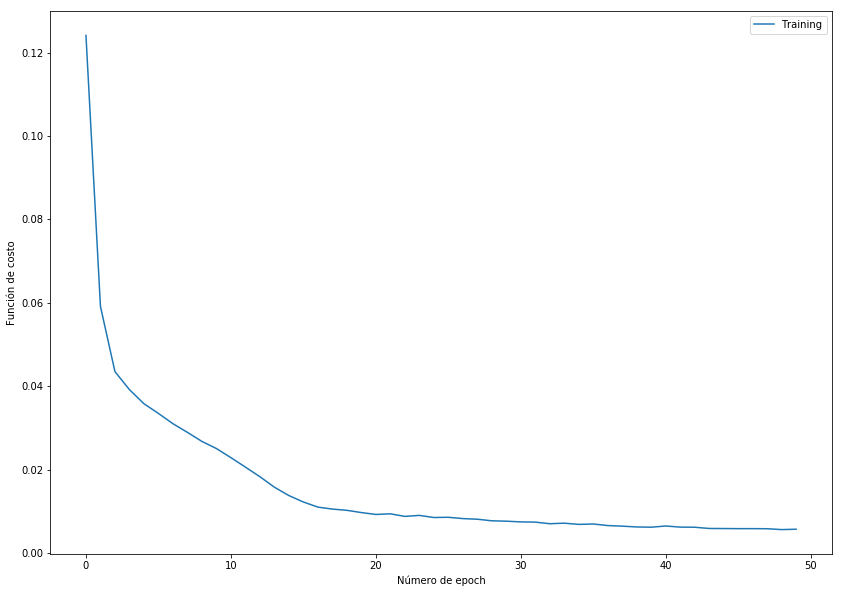

In [132]:
# Graficar la función de costo
plt.figure(figsize=(14,10))
plt.plot(history.history['loss'], label="Training")
plt.xlabel("Número de epoch")
plt.ylabel("Función de costo")
plt.legend();

In [130]:
# Predicciones de conjuntos de datos
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invertir las predicciones con el scaler
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# Calcular el RMSE
trainScore = np.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.55 RMSE
Test Score: 0.70 RMSE


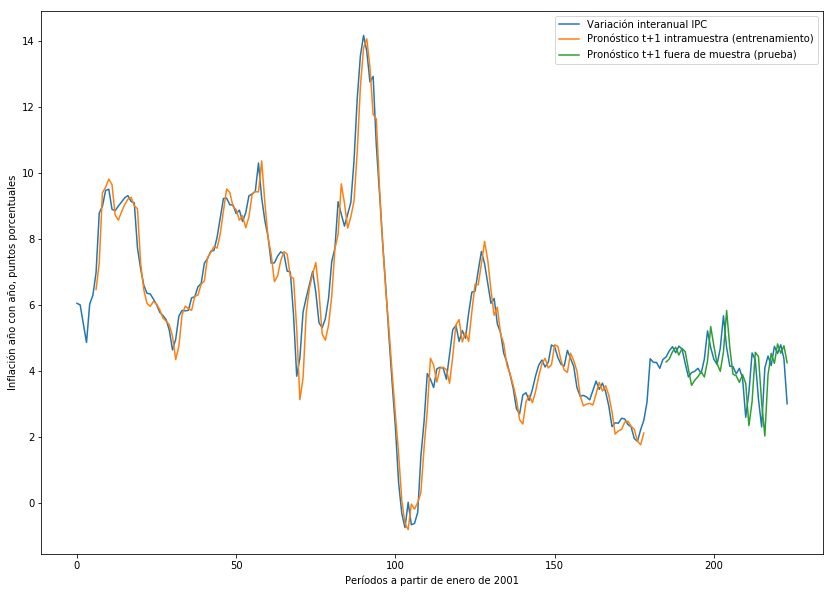

In [131]:
# Correr las predicciones de enrenamiento para graficar
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, :] = trainPredict

# Correr las predicciones de prueba para graficar
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LOOK_BACK*2) : len(dataset), :] = testPredict

# Graficar los valores observados y ajustados
plt.figure(figsize=(14,10))
plt.plot(scaler.inverse_transform(dataset), label="Variación interanual IPC")
plt.plot(trainPredictPlot, label="Pronóstico t+1 intramuestra (entrenamiento)")
plt.plot(testPredictPlot, label="Pronóstico t+1 fuera de muestra (prueba)")

plt.xlabel("Períodos a partir de enero de 2001")
plt.ylabel("Inflación año con año, puntos porcentuales")
plt.legend();
plt.show();

# Conclusiones

En este ejercicio se ajusta un modelo de redes neuronales recurrentes para pronosticar la inflación interanual en GUatemala a partir de la secuencia de los últimos 6 valores observados. Como se muestra en la figura anterior, el modelo resulta muy efectivo en el pronóstico de corto plazo de la inflación. En este ejercicio de series de tiempo podría experimentarse con una mayor cantidad de rezagos (*time steps*) para evaluar la qué tanto influye el número de rezagos en el pronóstico del período siguiente. Similarmente, podría experimentarse con un modelo de secuencias, que permita obtener una mayor cantidad de pronósticos hacia adelante.

Se puede concluir que este tipo de modelos son muy útiles en la modelación de datos de series de tiempo, pudiéndose utilizar en conjunto con maś variables (modelos multivariados) y para modelar cualquier tipo de secuencia.